In [1]:
import time

import numpy as np
import pandas as pd
from scipy import ndimage
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import cv2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

In [3]:
from utils.params import *
from utils.filename import *
from utils.image import *
import utils.models as models
from utils.read_activations import *

# dir(models)

Using TensorFlow backend.


In [4]:
train_masks = pd.read_csv(TRAIN_MASKS_CSV_PATH)
    
metadata = pd.read_csv(METADATA_CSV_PATH)
    
train_masks.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [12]:
import imp
imp.reload(models)
man_model = models.get_manufacturer_model()

In [17]:
man_model.load_weights('models/manufacturer_model.best_weights.hdf5')


In [4]:
import imp
imp.reload(models)
# imp.reload(losses)
baseline_model = models.get_baseline_model()
baseline_model.summary()

<module 'utils.models' from 'D:\\tree\\UdacityMachineLearning\\MLNDCapstone\\utils\\models.py'>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 1)       801       
Total params: 5,889
Trainable params: 5,889
Non-trainable params: 0
_________________________________________________________________


In [5]:
baseline_model.load_weights('models/baseline_model.best_weights.hdf5')

In [8]:
sample_car_code = '00087a6bd4dc'
sample_angle_code = '04'

In [13]:
from utils.image import *
imp.reload(utils.image)
imp.reload(utils.filename)

<module 'utils.image' from 'D:\\tree\\UdacityMachineLearning\\MLNDCapstone\\utils\\image.py'>

<module 'utils.filename' from 'D:\\tree\\UdacityMachineLearning\\MLNDCapstone\\utils\\filename.py'>

numpy.ndarray

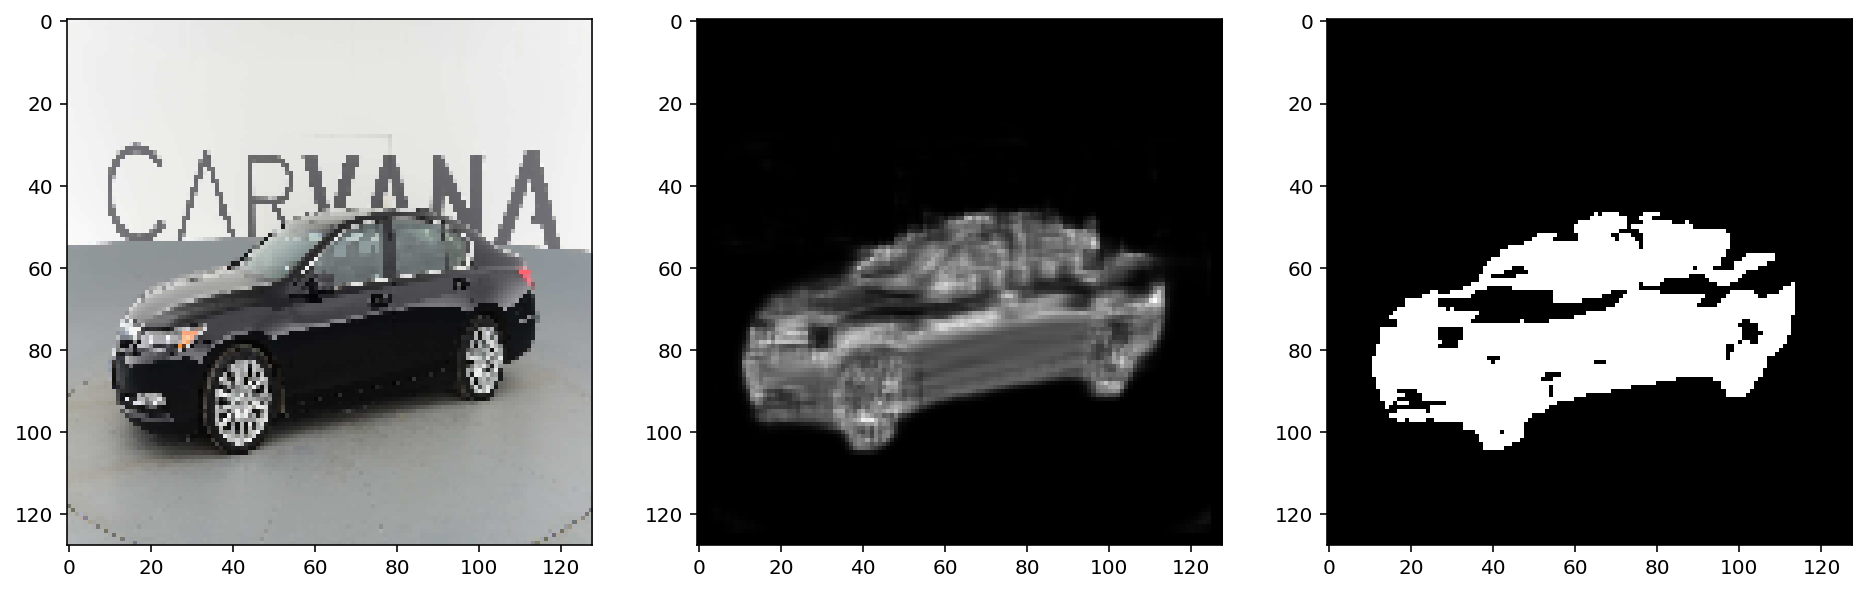

In [54]:

sample = read_image(sample_car_code, sample_angle_code)

fig, ax = plt.subplots(1, 3, figsize=(16, 16))
# ax = ax.ravel()

sample = resize(sample)
x_batch = []
x_batch.append(sample)
x_batch = np.array(x_batch, np.float32) /255
sample_pred = baseline_model.predict(x_batch).squeeze()

sample.__class__
ax[0].imshow(sample)
ax[1].imshow(sample_pred, cmap='gray')
ax[2].imshow(sample_pred > 0.01, cmap='gray')
# plt.imshow(sample_pred > .5, cmap = 'gray')

0.037414499

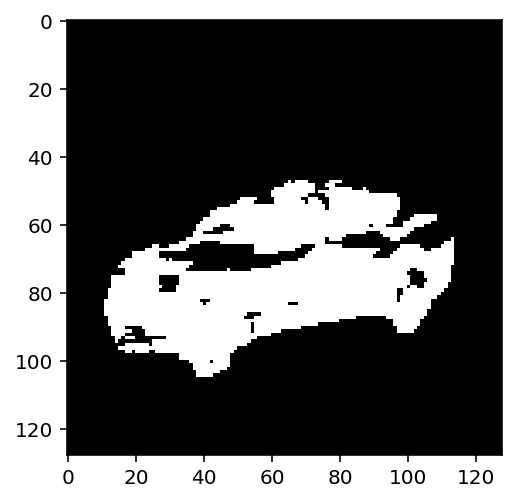

In [38]:
np.max(sample_pred)
plt.imshow(sample_pred > .01, cmap = 'gray')

<module 'utils.vis' from 'D:\\tree\\UdacityMachineLearning\\MLNDCapstone\\utils\\vis.py'>

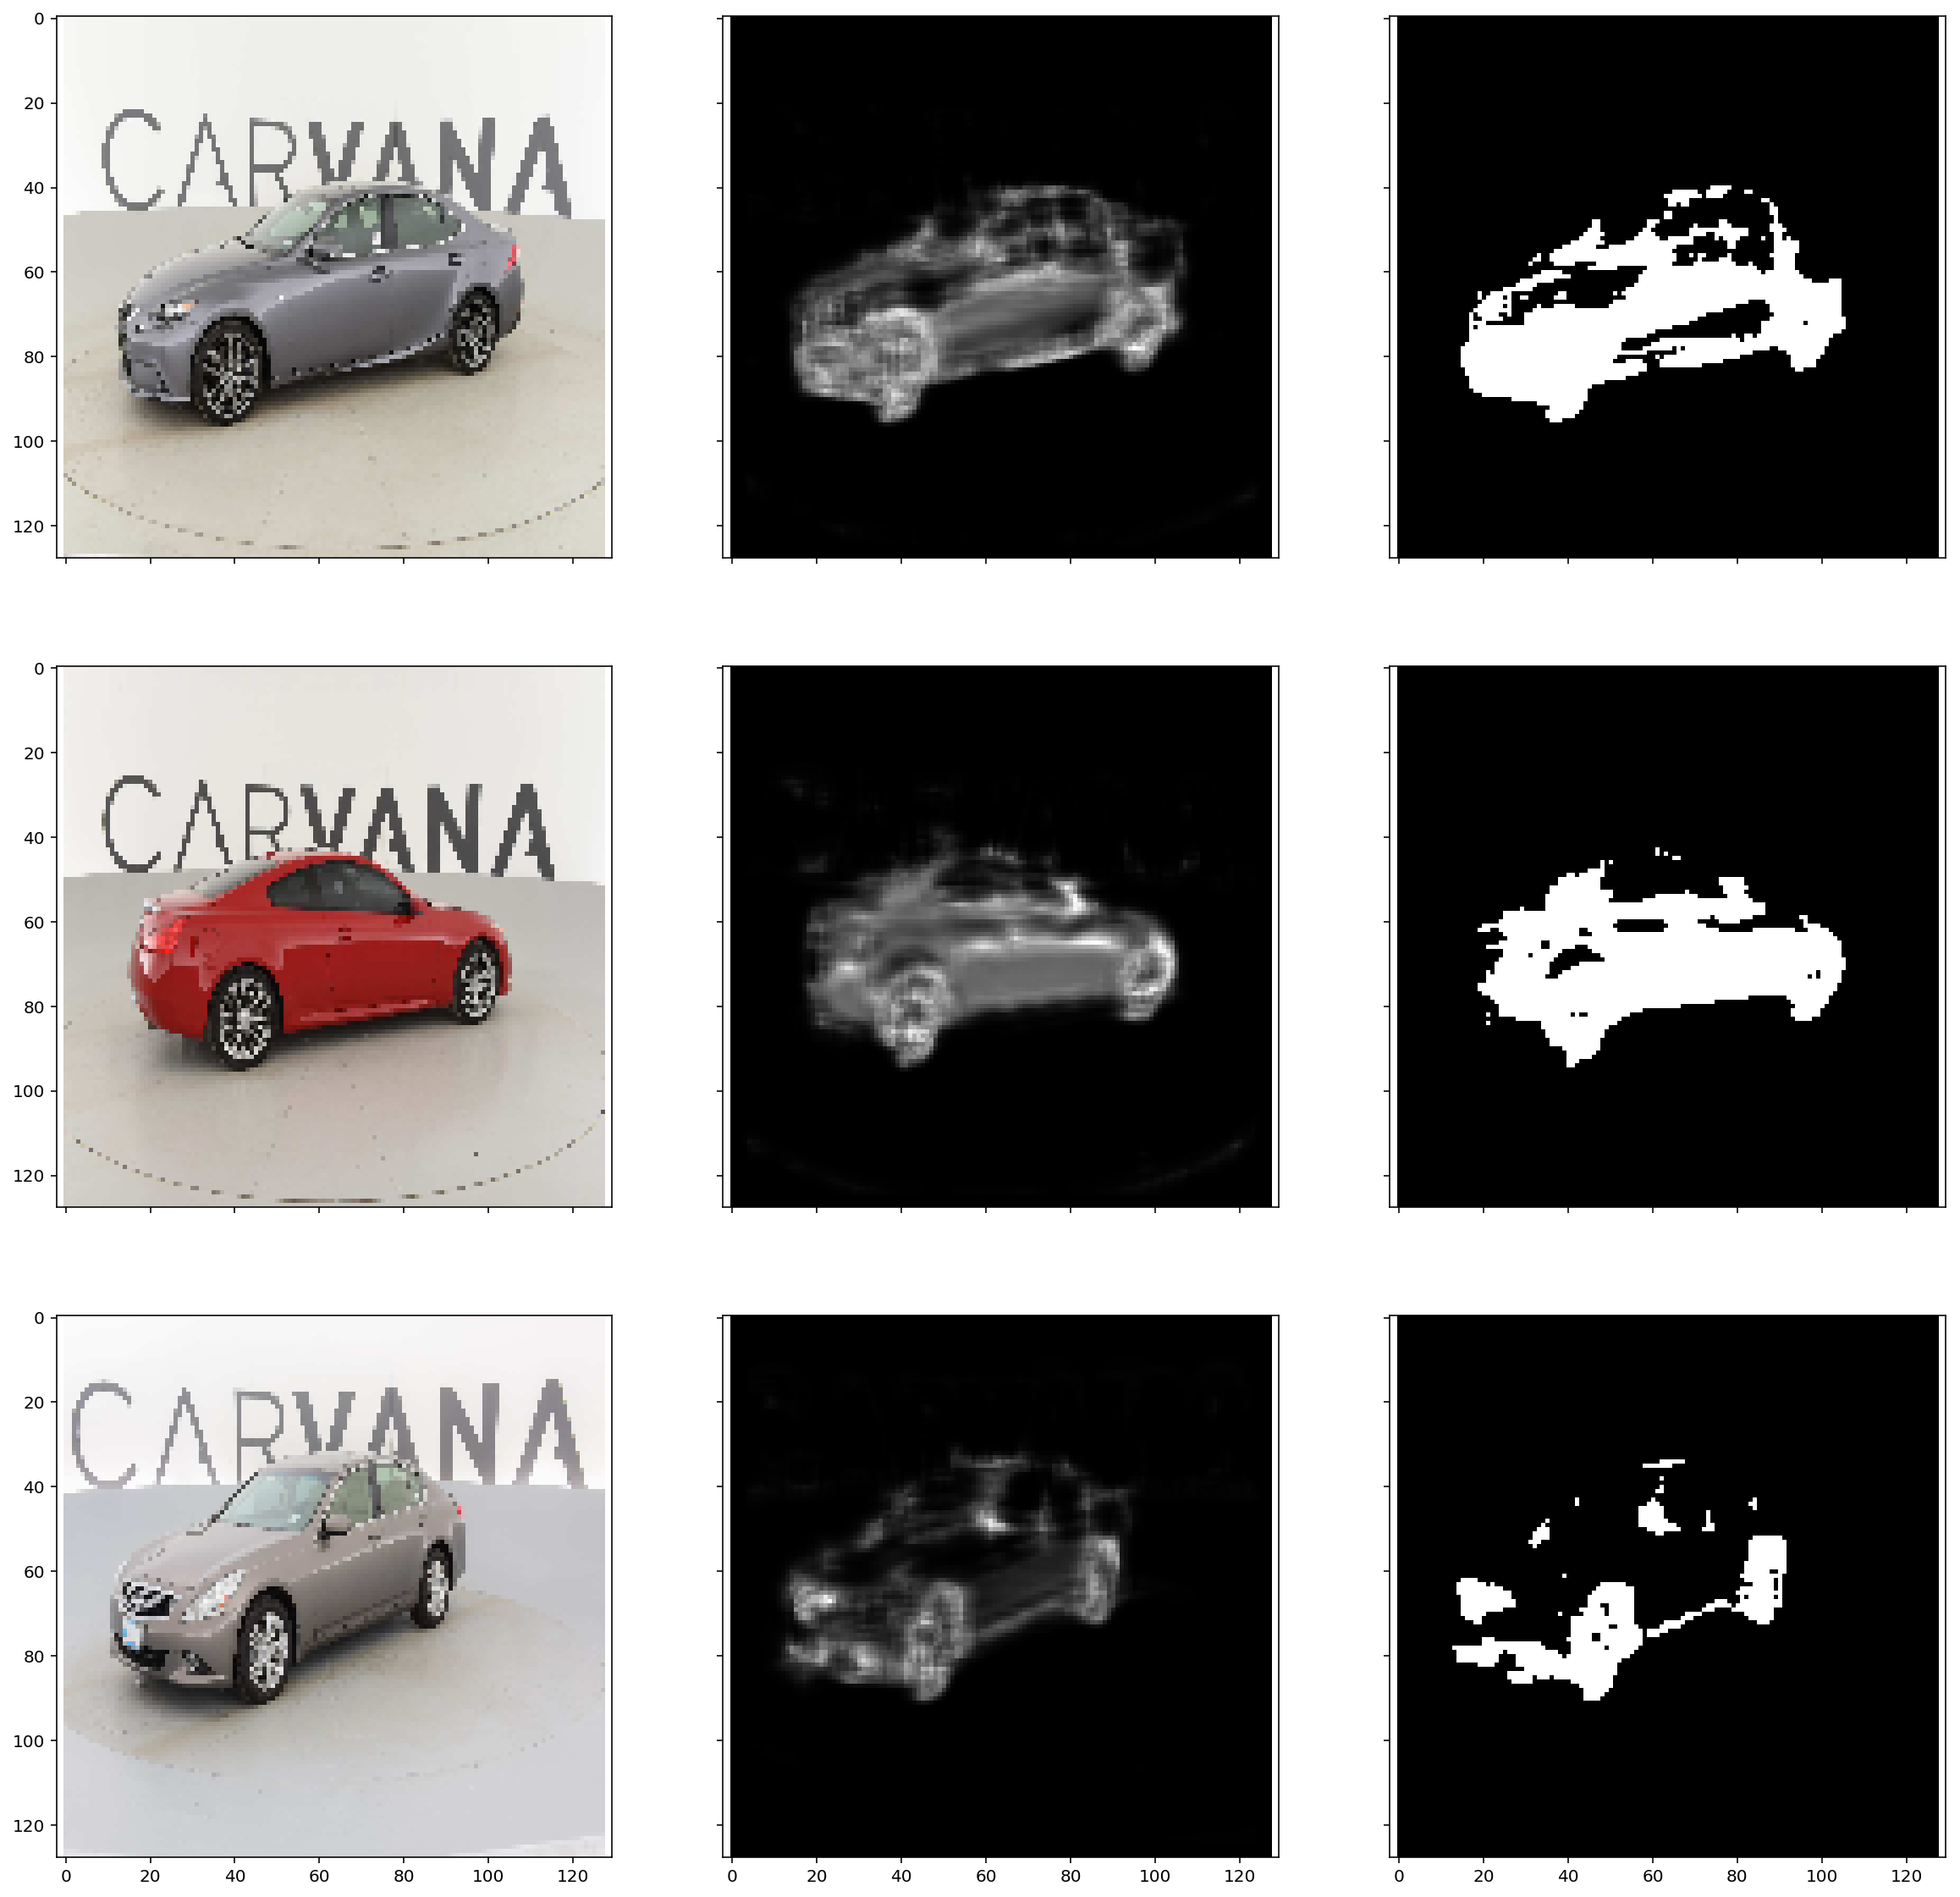

In [59]:
from utils.vis import *
imp.reload(utils.vis)

vis_baseline_predictions(baseline_model)

In [1]:
imp.reload(utils.image)
import inspect

# dir(read_image)
inspect.signature(read_image)
# read_image.__dict__

NameError: name 'imp' is not defined

In [24]:
# imp.reload(utils.params)
# imp.reload(utils.data)
# imp.reload(utils.image)
# imp.reload(utils.filename)

import utils.data as data
import utils.encoder as encoder

threshold = 0.001

orig_width = 1918
orig_height = 1280

rles = []
ids_test = data.list_test_files()
print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), BATCH_SIZE))
for start in tqdm(range(0, len(ids_test), BATCH_SIZE)):
    x_batch = []
    end = min(start + BATCH_SIZE, len(ids_test))
    ids_test_batch = ids_test[start:end]
    for id in ids_test_batch:
        car_code, angle_code = filename_to_code(id)
        img = read_image(car_code, angle_code, test = True)
        img = resize(img)
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    preds = baseline_model.predict_on_batch(x_batch)
    preds = np.squeeze(preds, axis = 3)
    for pred in preds:
        prob = cv2.resize(pred, (orig_width, orig_height))
        mask = prob > threshold
        rle = encoder.run_length_encode(mask)
        rles.append(rle)

print("Generating submission file,..")
df = pd.DataFrame({'img':names, 'rle_mask':rles})
df.to_csv('submit/baseline_{}.csv.gz'.format(threshold), index = False, compression='gzip')


Predicting on 100064 samples with batch_size = 16...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 6254/6254 [1:39:57<00:00,  1.01it/s]


Generating submission file,..


NameError: name 'names' is not defined

In [26]:
print("Generating submission file,..")
df = pd.DataFrame({'img':ids_test, 'rle_mask':rles})
df.to_csv('subm/baseline_{}.csv.gz'.format(threshold), index = False, compression='gzip')
print("File created,..")

Generating submission file,..


In [ ]:
from skimage import measure, morphology
limg = measure.label(mask)
props = measure.regionprops(limg)
props = sorted(props, key=lambda p: -p.area)
# Erase all except the biggest blob
mask &= (limg == props[0].label)

In [9]:
sample = read_image(sample_car_code, sample_angle_code)
sample = resize(sample)
x_batch = []
x_batch.append(sample)
x_batch = np.array(x_batch, np.float32) /255


In [ ]:
activations = get_activations(baseline_model, x_batch, print_shape_only = True)

Displaying activation map 0


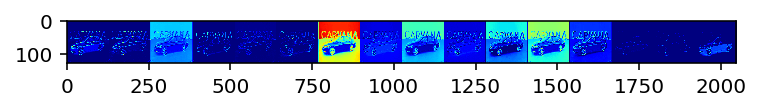

Displaying activation map 1


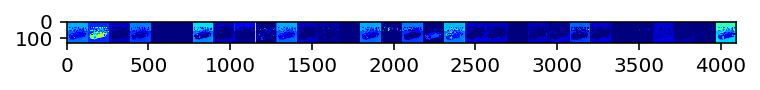

Displaying activation map 2


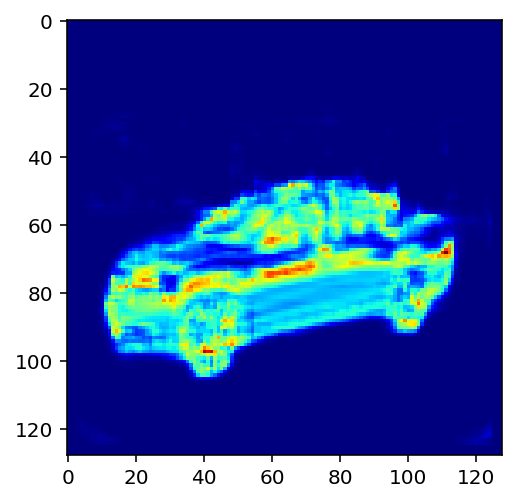

In [11]:
display_activations(activations)

In [43]:
layers = baseline_model.layers

In [45]:
for layer in layers:
    print (layer.name)

conv2d_4
conv2d_5
conv2d_6


In [46]:
from vis.utils import utils

In [48]:
layer_idx = utils.find_layer_idx(baseline_model, 'conv2d_6')
layer_idx

2

In [40]:
from keras import activations
#swap softmax with linear
baseline_model.layers[2].activation = activations.linear
baseline_model = utils.apply_modifications(baseline_model)

ValueError: Unknown loss function:bce_dice_loss

<module 'utils.vis' from 'D:\\tree\\UdacityMachineLearning\\MLNDCapstone\\utils\\vis.py'>

num_filters :  1
fig_size :  1


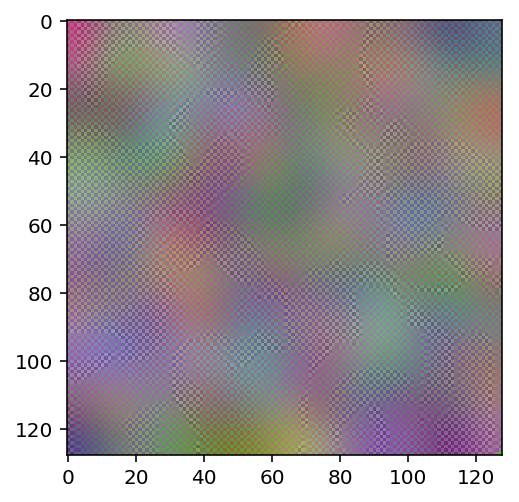

In [10]:
import utils.vis as visutils
import imp
imp.reload(visutils)

layer_idx = 2
visutils.vis_activation_maximizations(baseline_model, layer_idx)
